# Przewidywanie zwycięzcy rundy w grze Counter Strike: Global Offensive

# Dane

Zbiór danych składa się ze snapshotów rund z około 700 meczów z profesjonalnych turniejów
rozgrywanych w 2019 i 2020 roku. Snapshoty, czyli zestawienie pewnych stanów kluczowych ele-
mentów rozgrywki, były rejestrowane podczas gry co 20 sekund aż do rozstrzygnięcia danej rundy.
Łączna liczba zapisanych snapshotów wynosi 122411. Część tych rekordów będzie traktowana jako
zbiór danych uczących, a pozostała część jako część danych testów. Każdy rekord traktowany jest
jako pojedynczy, niezależny element do analizy danych.

# Czym jest klasyfikator MLP

Perceptron wielowarstwowy (MLP) to model sztucznej sieci neuronowej ze sprzężeniem do przodu, który odwzorowuje zestawy danych wejściowych na zestaw odpowiednich danych wyjściowych. MLP składa się z wielu warstw, a każda warstwa jest w pełni połączona z następną. Węzły warstw to neurony z nieliniowymi funkcjami aktywacji, z wyjątkiem węzłów warstwy wejściowej. Pomiędzy warstwą wejściową a wyjściową może znajdować się jedna lub więcej nieliniowych warstw ukrytych.

# Import bibliotek i danych

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Data/csgo_round_snapshots.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [5]:
df.isnull().sum().sum()

0

In [6]:
df.shape

(122410, 97)

# Przeprocesowanie danych

W pierwszej koleności sprawdźmy liczność klas:

In [7]:
df['round_winner'].value_counts()

T     62406
CT    60004
Name: round_winner, dtype: int64

<AxesSubplot:xlabel='round_winner', ylabel='count'>

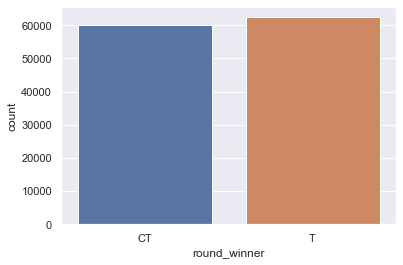

In [8]:
sns.set_theme(style="darkgrid")
sns.countplot(x='round_winner', data=df)

Następnie chcemy przekonwertwać wszystkie kolumny na wartości liczbowe:

In [9]:
col = df.drop(df.select_dtypes(np.number), axis = 1).columns
col

Index(['map', 'bomb_planted', 'round_winner'], dtype='object')

In [10]:
lbl = LabelEncoder()
for value in col:
    df[value] = lbl.fit_transform(df[value])

In [11]:
df['bomb_planted'] = df['bomb_planted'].astype(np.int16)

In [12]:
cols = [f for f in df.columns if f not in ['round_winner']]

Dodatkowo każda wartość zostaje znormalizowana.

In [13]:
scaler = RobustScaler()

for value in cols:
    scaler = RobustScaler()
    df[value] = scaler.fit_transform(df[[value]])

Na koniec dzielimy dane na wektor danych oraz wektor wyników.

In [46]:
x = df.drop(['round_winner'], axis = 1)
y = df['round_winner']

In [15]:
len(cols)

96

Finalnie każdy rekord zawiera 96 atrybutów, które prezentują się w sposób następujący:

In [16]:
x.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,0.715105,-0.857143,-0.857143,-0.666667,0.0,0.000000,0.000000,-1.291096,-1.136054,-0.112782,-0.191489,-0.5,-0.6,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
1,0.545726,-0.857143,-0.857143,-0.666667,0.0,0.000000,0.000000,0.078767,-0.115646,-0.368421,-0.395137,-0.5,-0.6,0.000000,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
2,0.010000,-0.857143,-0.857143,-0.666667,0.0,-0.726667,-0.561798,-0.284247,-0.455782,-0.357143,-0.404255,-0.5,-0.6,0.000000,-1.0,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
3,-0.168575,-0.857143,-0.857143,-0.666667,0.0,-0.726667,-0.561798,-0.284247,-0.455782,-0.357143,-0.404255,-0.5,-0.6,0.000000,-1.0,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
4,0.714837,-0.714286,-0.857143,-0.666667,0.0,0.000000,0.000000,-0.633562,-1.136054,0.966165,0.218845,-0.5,-0.6,0.000000,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0


## Wybór atrybutów

W pierwszej kolejności sprawdzimy, które atrybuty mają największy wpływ na klasy. W tym celu wykorzystamy model _Random Forest Regressor_, który dopasowuje szereg klasyfikujących drzew decyzyjnych do różnych podpróbek zbioru danych i wykorzystuje uśrednianie w celu poprawy dokładności predykcyjnej i kontroli nadmiernego dopasowania.

In [18]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(x, y)

RandomForestRegressor(n_estimators=150)

Po stworzeniu i wyuczeniu modelu sortujemy tablice zawierającą informacje jak duży wpływ mają konkretne atrybuty w podejmowaniu decyzji.

In [47]:
indexes = rf.feature_importances_.argsort()

Wpływ poszczególnych atrybutów został przedstawiony na wykresie:

Text(0.5, 0, 'Feature Importance')

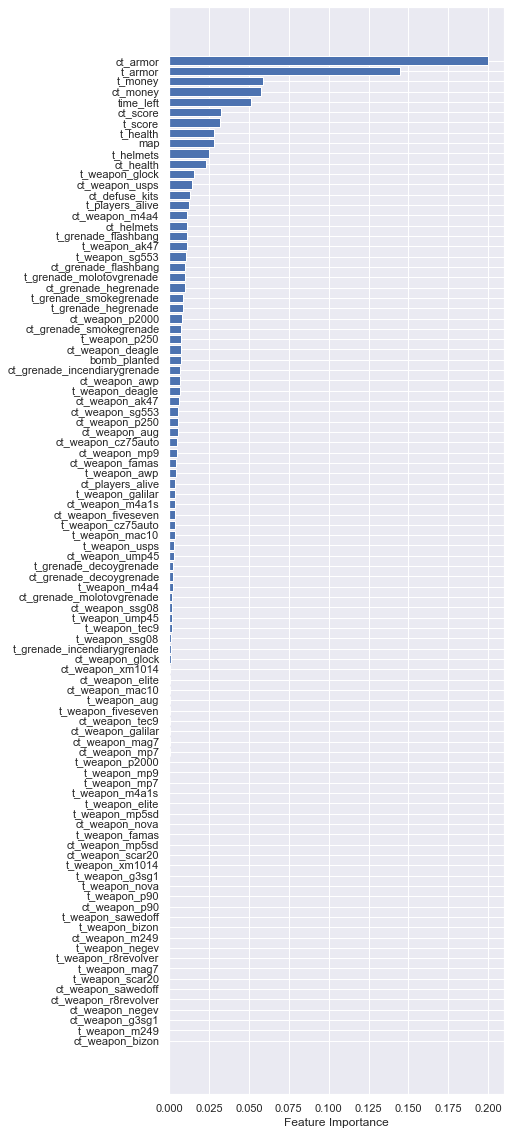

In [48]:
plt.figure(figsize=(6,20))
plt.barh(x.columns[indexes], rf.feature_importances_[indexes])
plt.xlabel("Feature Importance")

Następnie możemy odrzucić te atrybuty, które nie mają lub mają niski wpływ na podejmowanie decyzji. W tym celu wybraliśmy te atrybuty dla których wartość parametru _feature_importance_ jest większa od wartości 0.005.

In [20]:
importances = rf.feature_importances_[indexes]
indexes = indexes[np.argwhere(importances > 0.005)]
indexes = np.concatenate(indexes).ravel().tolist()
columns = x.columns[indexes]
x = x[columns]

W tym momencie możemy sprawdzić ile atrybutów pozostało po selekcji.

In [25]:
x.shape

(122410, 38)

Mamy 38 atrybutów, które prezentują się w sposób następujący:

In [26]:
x.head()

,ct_weapon_cz75auto,ct_weapon_aug,ct_weapon_p250,ct_weapon_sg553,ct_weapon_ak47,t_weapon_deagle,ct_weapon_awp,ct_grenade_incendiarygrenade,bomb_planted,ct_weapon_deagle,t_weapon_p250,ct_grenade_smokegrenade,ct_weapon_p2000,t_grenade_hegrenade,t_grenade_smokegrenade,ct_grenade_hegrenade,t_grenade_molotovgrenade,ct_grenade_flashbang,t_weapon_sg553,t_weapon_ak47,t_grenade_flashbang,ct_helmets,ct_weapon_m4a4,t_players_alive,ct_defuse_kits,ct_weapon_usps,t_weapon_glock,ct_health,t_helmets,map,t_health,t_score,ct_score,time_left,ct_money,t_money,t_armor,ct_armor
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,-0.333333,0.0,-0.5,-0.333333,0.0,-0.5,-0.333333,-0.5,-0.5,0.0,-0.333333,0.333333,0.333333,0.000000,-0.6,-0.666667,0.000000,-0.857143,-0.857143,0.715105,-0.112782,-0.191489,-1.136054,-1.291096
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,0.333333,0.0,-0.5,-0.333333,0.0,-0.5,-0.333333,-0.5,-0.5,0.0,0.000000,0.333333,0.333333,0.000000,-0.6,-0.666667,0.000000,-0.857143,-0.857143,0.545726,-0.368421,-0.395137,-0.115646,0.078767
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.333333,0.0,-0.5,-0.333333,0.0,-0.5,-0.333333,-0.5,-0.5,-1.0,0.000000,0.333333,0.000000,-0.726667,-0.6,-0.666667,-0.561798,-0.857143,-0.857143,0.010000,-0.357143,-0.404255,-0.455782,-0.284247
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,-0.333333,0.0,-0.5,-0.333333,0.0,-0.5,-0.333333,-0.5,-0.5,-1.0,0.000000,0.333333,-0.333333,-0.726667,-0.6,-0.666667,-0.561798,-0.857143,-0.857143,-0.168575,-0.357143,-0.404255,-0.455782,-0.284247
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,-0.333333,0.0,-0.5,-0.333333,0.0,-0.5,-0.333333,-0.5,-0.5,0.0,0.000000,0.333333,0.333333,0.000000,-0.6,-0.666667,0.000000,-0.857143,-0.714286,0.714837,0.966165,0.218845,-1.136054,-0.633562


Mając już przetworzenone dane możemy wydzielić z nich zbiór treningowy oraz testowy.

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.1, random_state = 0)

In [40]:
x_train.shape

(110169, 38)

In [41]:
x_test.shape

(12241, 38)

Mamy 110169 rekordów w zbiorze treningowym oraz 12241 w zbiorze testowym. W tym momencie możemy rozpocząć inicjalizacje modelu.

## Definicja i inicjalizacja modelu

# Podział prac

Ogólny podział pracy:
1. ~~Wybór niezbędnych bibliotek - Jakub Michalak~~,
1. ~~Walidacja i wydzielenie danych treningowych - Damian Opoka~~,
1. ~~Analiza i przygotowanie danych - Damian Opoka~~,
1. Definicja modelu - Adam Ryl,
1. Weryfikacja krzyżowa - Adam Ryl,
1. Dostosowanie hiperparametrów - Jakub Michalak,
1. Wygenerowanie wyników - Piotr Kryczka,
1. Analiza wyników - Piotr Kryczka.